In [5]:
import numpy as np  # linear algebra
import cv2 # opencv
import matplotlib.pyplot as plt # image plotting
# keras
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

In [6]:
train_dir = "../input/face-mask-12k-images-dataset/Face Mask Dataset/Train"
test_dir = "../input/face-mask-12k-images-dataset/Face Mask Dataset/Test"
val_dir = "../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation"

In [16]:
datagenerator = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2
)
train_generator = datagenerator.flow_from_directory(
    directory=train_dir, target_size=(128, 128), class_mode="categorical", batch_size=32
)

# Validation data
val_generator = datagenerator.flow_from_directory(
    directory=val_dir, target_size=(128, 128), class_mode="categorical", batch_size=32
)

# Test data
test_generator = datagenerator.flow_from_directory(
    directory=val_dir, target_size=(128, 128), class_mode="categorical", batch_size=32
)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [17]:
vgg19_model = VGG19(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

for layer in vgg19_model.layers:
    layer.trainable = False

# Initialize a sequential model
model = Sequential()
model.add(vgg19_model)
model.add(Flatten())
model.add(Dense(2, activation="sigmoid"))
model.summary()

# Compiling the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")

80134624/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 2)                 16386     
                                                                 
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


In [18]:
model_history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=len(train_generator) // 32,
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator) // 32,
)

/tmp/ipykernel_32/1691900303.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(


Epoch 1/20
9/9 [==============================] - 39s 4s/step - loss: 0.4689 - accuracy: 0.7847
Epoch 2/20
9/9 [==============================] - 35s 4s/step - loss: 0.2235 - accuracy: 0.9201
Epoch 3/20
9/9 [==============================] - 34s 4s/step - loss: 0.1306 - accuracy: 0.9618
Epoch 4/20
9/9 [==============================] - 34s 4s/step - loss: 0.1487 - accuracy: 0.9514
Epoch 5/20
9/9 [==============================] - 34s 4s/step - loss: 0.1180 - accuracy: 0.9722
Epoch 6/20
9/9 [==============================] - 34s 4s/step - loss: 0.1078 - accuracy: 0.9653
Epoch 7/20
9/9 [==============================] - 34s 4s/step - loss: 0.0925 - accuracy: 0.9618
Epoch 8/20
9/9 [==============================] - 34s 4s/step - loss: 0.0672 - accuracy: 0.9896
Epoch 9/20
9/9 [==============================] - 34s 4s/step - loss: 0.0680 - accuracy: 0.9757
Epoch 10/20
9/9 [==============================] - 35s 4s/step - loss: 0.0431 - accuracy: 0.9896
Epoch 11/20
9/9 [======================

In [19]:
model_loss, model_acc = model.evaluate(test_generator)
print("Model has a loss of %.2f and accuracy %.2f%%" % (model_loss, model_acc*100))

25/25 [==============================] - 94s 4s/step - loss: 0.0637 - accuracy: 0.9800
Model has a loss of 0.06 and accuracy 98.00%


In [20]:
model.save('data/saved_model.h5')

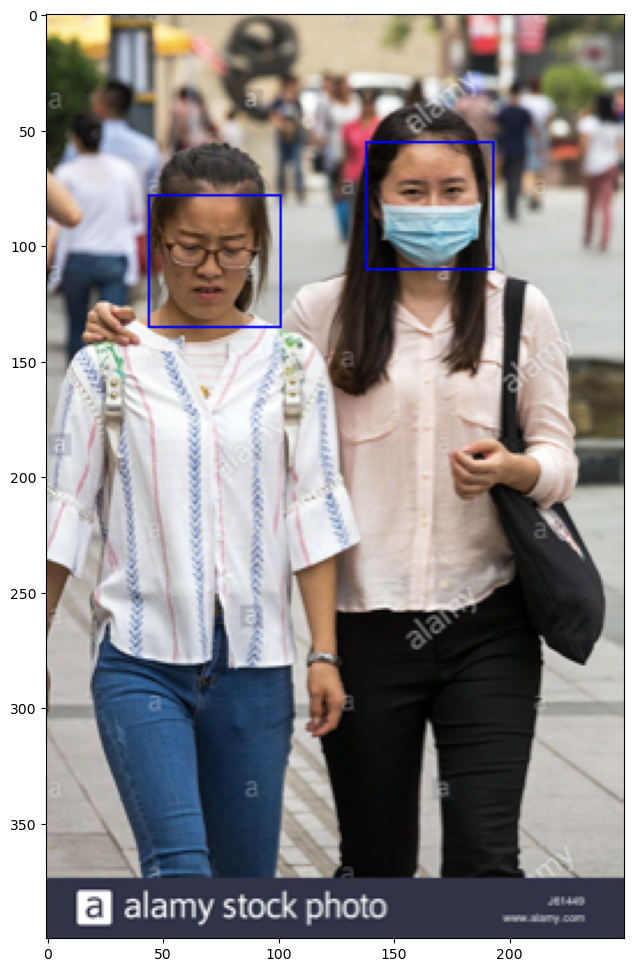

In [27]:
img = cv2.imread("../input/face-mask-detection/images/maksssksksss352.png")

# Keep a copy of coloured image
orig_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

# Convert image to grayscale
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

# loading haarcascade_frontalface_default.xml
face_detection_model = cv2.CascadeClassifier("../input/haar-cascades-for-face-detection/haarcascade_frontalface_default.xml")

# detect faces in the given image
return_faces = face_detection_model.detectMultiScale(
    img, scaleFactor=1.08, minNeighbors=4
)  # returns a list of (x,y,w,h) tuples

# plotting the returned values
for (x, y, w, h) in return_faces:
    cv2.rectangle(orig_img, (x, y), (x + w, y + h), (0, 0, 255), 1)

plt.figure(figsize=(12, 12))
plt.imshow(orig_img)

1/1 [==============================] - 0s 145ms/step


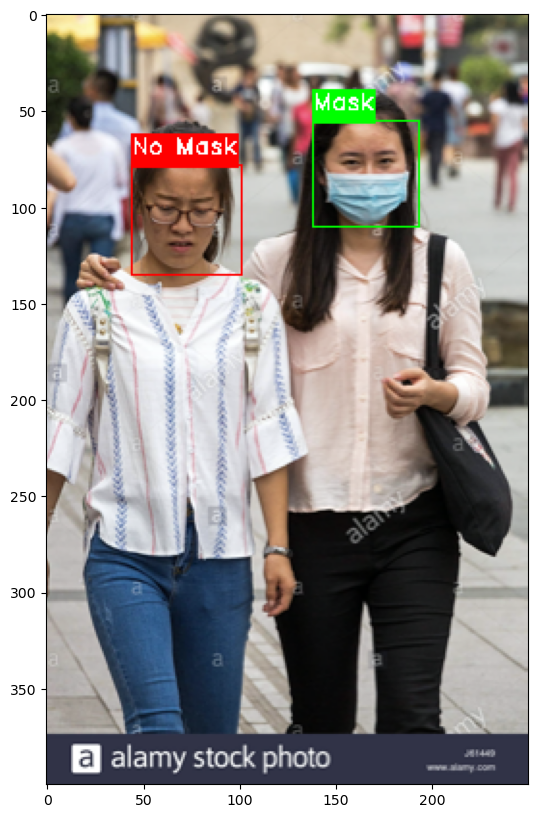

In [29]:
mask_det_label = {0: "Mask", 1: "No Mask"}
mask_det_label_colour = {0: (0, 255, 0), 1: (255, 0, 0)}
pad_y = 1  # padding for result text

main_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

# For detected faces in the image
for i in range(len(return_faces)):
    (x, y, w, h) = return_faces[i]
    cropped_face = main_img[y : y + h, x : x + w]
    cropped_face = cv2.resize(cropped_face, (128, 128))
    cropped_face = np.reshape(cropped_face, [1, 128, 128, 3]) / 255.0
    mask_result = model.predict(cropped_face)  # make model prediction
    print_label = mask_det_label[mask_result.argmax()] # get mask/no mask based on prediction
    label_colour = mask_det_label_colour[mask_result.argmax()] # green for mask, red for no mask

    # Print result
    (t_w, t_h), _ = cv2.getTextSize(
        print_label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1
    )  # getting the text size
    
    cv2.rectangle(
        main_img,
        (x, y + pad_y),
        (x + t_w, y - t_h - pad_y - 6),
        label_colour,
        -1,
    )
    cv2.putText(
        main_img,
        print_label,
        (x, y - 6),
        cv2.FONT_HERSHEY_DUPLEX,
        0.4,
        (255, 255, 255), # white
        1,
    )  # print text

    cv2.rectangle(
        main_img,
        (x, y),
        (x + w, y + h),
        label_colour,
        1,
    )  # draw bounding box on face

plt.figure(figsize=(10, 10))
plt.imshow(main_img)  # display image